### 抓取行政边界坐标点
#### 高德API：
https://lbs.amap.com/api/webservice/guide/api/district  
* (1)keywords = 上海  
规则：只支持单个关键词语搜索关键词支持：行政区名称、citycode、adcode
例如，在subdistrict=2，搜索省份（例如山东），能够显示市（例如济南），区（例如历下区）

* (2)subdistrict = 3  
规则：设置显示下级行政区级数（行政区级别包括：国家、省/直辖市、市、区/县4个级别）
可选值：0、1、2、3
0：不返回下级行政区；
1：返回下一级行政区；
2：返回下两级行政区；
3：返回下三级行政区；

* (3)extensions = all  
此项控制行政区信息中返回行政区边界坐标点； 可选值：base、all;
base:不返回行政区边界坐标点；
all:只返回当前查询district的边界值，不返回子节点的边界值；

* (4)返回polyline 行政区边界坐标点  
当一个行政区范围，由完全分隔两块或者多块的地块组成，每块地的 polyline 坐标串以 | 分隔 。

#### 参考文章网址：
http://zhaoxuhui.top/blog/2017/07/20/%E8%8E%B7%E5%8F%96%E8%A1%8C%E6%94%BF%E5%8C%BA%E8%BE%B9%E7%95%8C%E5%92%8C%E5%88%A9%E7%94%A8GDAL%E7%94%9F%E6%88%90shp%E6%96%87%E4%BB%B6.html

https://www.cnblogs.com/ITGIS/p/3542601.html

#### 修正原文中没有设置参考坐标系  
* 添加wgs84坐标系：   https://blog.csdn.net/theonegis/article/details/80554993  
* 添加投影：   http://geopandas.org/projections.html
* 多个面合并成为一个文件（ogr资料）  https://pcjericks.github.io/py-gdalogr-cookbook/geometry.html#create-a-linestring
* 增加code等信息

#### 其他资料
https://stackoverflow.com/questions/13198391/create-a-shape-file

https://blog.csdn.net/sinat_29675423/article/details/87434839

https://pcjericks.github.io/py-gdalogr-cookbook/geometry.html#create-a-multipoint

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import urllib
import json
import gdal
import ogr
import osr
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def GetBoundary(keywords):
    key = '2ec800bea308e094ad206a582f87e206'
    subdistrict = 3
    extensions = 'all'
    params = {'key': key,
             'keywords': keywords,
             'subdistrict': 3,
             'extensions': 'all'}
    url = 'https://restapi.amap.com/v3/config/district?'
    request = url + urllib.parse.urlencode(params)
    response = urllib.request.urlopen(request)
    web_data = response.read()
    data = json.loads(web_data)
    polyline = data['districts'][0]['polyline']
    
    poly_num = polyline.split('|').__len__()
    print('{}存在{}块'.format(keywords,poly_num))

    blocks = polyline.split('|')  # 当包含多块地的时切分成至少两块；当只有一块地时无影响

    polylines = []
    str_polylines = []
    for item in blocks:
        line = item.split(';')
        polylines.append(line)

    # 依次遍历每一条多段线，拼接对应格式的字符串
    for line in polylines:
        list_lat = []
        list_lon = []
        for item in line:
            res = item.split(',')
            list_lon.append(res[0])
            list_lat.append(res[1])
        result_str = ''
        # print(list_lat.__len__(), "points are read.")
        for i in range(list_lat.__len__()):
            result_str += list_lon[i] + " " + list_lat[i] + ","
        result_str = "POLYGON ((" + result_str[:-1] + "))"
        str_polylines.append(result_str)
    return poly_num, str_polylines

In [4]:
def WriteVectorFile(filename, content):
    # 单块文件
    # 为了支持中文路径，添加下面这句代码
    gdal.SetConfigOption("GDAL_FILENAME_IS_UTF8", "NO")
    # 为了使属性表字段支持中文，添加下面这句
    gdal.SetConfigOption("SHAPE_ENCODING", "")

    # 注册所有的驱动
    ogr.RegisterAll()

    # 创建数据
    strDriverName = "ESRI Shapefile"
    oDriver = ogr.GetDriverByName(strDriverName)
    if oDriver is None:
        print(strDriverName, "驱动不可用")

    # 创建WGS84空间参考
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    srs.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
       
    # 创建数据源
    oDS = oDriver.CreateDataSource(filename)
    if oDS == None:
        print(filename, "创建文件失败！")

    # 创建图层，创建一个多边形图层，这里没有指定空间参考，如果需要的话，需要在这里进行指定
    papszLCO = []
    oLayer = oDS.CreateLayer("Polygon", srs, ogr.wkbPolygon, papszLCO)
    if oLayer == None:
        print("图层创建失败！\n")

    # 下面创建属性表
    # 先创建一个叫FieldID的整型属性
    oFieldID = ogr.FieldDefn("FieldID", ogr.OFTInteger)
    oLayer.CreateField(oFieldID, 1)

    # 再创建一个叫FeatureName的字符型属性，字符长度为50
    oFieldName = ogr.FieldDefn("FieldName", ogr.OFTString)
    oFieldName.SetWidth(100)
    oLayer.CreateField(oFieldName, 1)

    oDefn = oLayer.GetLayerDefn()

    for item in content:
        # 创建要素
        oFeature = ogr.Feature(oDefn)
        oFeature.SetField(0, 0)
        oFeature.SetField(1, "Border")
        geom = ogr.CreateGeometryFromWkt(item)
        oFeature.SetGeometry(geom)
        oLayer.CreateFeature(oFeature)

    oDS.Destroy()
#     print("形文件创建完成！\n")

In [5]:
def WriteVectorFile_Multipolygon(filename, content):
    # 多块文件
    gdal.SetConfigOption("GDAL_FILENAME_IS_UTF8", "NO")  # 为了支持中文路径
    gdal.SetConfigOption("SHAPE_ENCODING", "")  # 为了使属性表字段支持中文

    ogr.RegisterAll()  # 注册所有的驱动

    # 创建数据
    strDriverName = "ESRI Shapefile"
    driver = ogr.GetDriverByName(strDriverName)
    if driver is None: print(strDriverName, "驱动不可用")

    # 创建WGS84空间参考
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    srs.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    # 创建数据源
    ds = driver.CreateDataSource(filename)
    if ds == None: print(filename, "创建文件失败！")

    # 创建图层，创建一个多边形图层，这里没有指定空间参考，如果需要的话，需要在这里进行指定
    papszLCO = []
    layer = ds.CreateLayer("MultiPolygon", srs, ogr.wkbMultiPolygon, papszLCO)
    if layer == None: print('图层创建失败！\n')

    # 下面创建属性表
    # 先创建一个叫FieldID的整型属性
    fieldID = ogr.FieldDefn("FieldID", ogr.OFTInteger)
    layer.CreateField(fieldID, 1)

    # 再创建一个叫FeatureName的字符型属性，字符长度为50
    fieldName = ogr.FieldDefn("FieldName", ogr.OFTString)
    fieldName.SetWidth(100)
    layer.CreateField(fieldName, 1)

    Defn = layer.GetLayerDefn()

    featureMulty = ogr.Feature(Defn)
    featureMulty.SetField(0, 1)
    featureMulty.SetField(1, "Border")

    geoMulty = ogr.Geometry(ogr.wkbMultiPolygon)
    for item in content:
        # 创建要素  
        poly = ogr.CreateGeometryFromWkt(item)
        geoMulty.AddGeometryDirectly(poly);

    featureMulty.SetGeometry(geoMulty);
    layer.CreateFeature(featureMulty)
    ds.Destroy()

In [13]:
def excute_main_code(keywords, filename):
    # 爬取行政边界
    block_num, zone = GetBoundary(keywords=keywords)
    if block_num > 1: WriteVectorFile_Multipolygon(filename=filename,content=zone)
    else: WriteVectorFile(filename=filename, content=zone)      

上海市存在11块
江苏存在10块
嘉定区存在1块


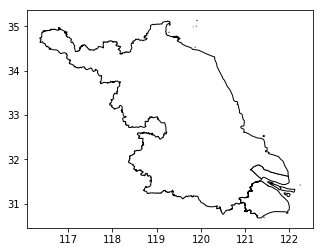

In [14]:
if __name__ == '__main__':
    excute_main_code(keywords='上海市',filename='C:\\Users\zhpy\Desktop\ShangHai.shp')
    excute_main_code(keywords='江苏',filename='C:\\Users\zhpy\Desktop\JiangSu.shp')
    excute_main_code(keywords='嘉定区',filename='C:\\Users\zhpy\Desktop\Jiading.shp')
    
    ShangHai = gpd.read_file('C:\\Users\zhpy\Desktop\ShangHai.shp')
    JiangSu = gpd.read_file('C:\\Users\zhpy\Desktop\JiangSu.shp')
    JiaDing = gpd.read_file('C:\\Users\zhpy\Desktop\JiaDing.shp')
    ShpFile = pd.concat([ShangHai,JiangSu,Jiading])
    ShpFile.plot(color='white',edgecolor='black')

In [ ]:
keywords = '嘉定'

key = '2ec800bea308e094ad206a582f87e206'
subdistrict = 3
extensions = 'all'
params = {'key': key,
         'keywords': keywords,
         'subdistrict': 3,
         'extensions': 'all'}
url = 'https://restapi.amap.com/v3/config/district?'
request = url + urllib.parse.urlencode(params)
response = urllib.request.urlopen(request)
web_data = response.read()
data = json.loads(web_data)
polyline = data['districts'][0]['polyline']

if polyline.count('|') == 0: print('{}区域相连，只有1块'.format(keywords))
else: print('{}区域存在{}块'.format(keywords,polyline.split('|').__len__()))

blocks = polyline.split('|')  # 当包含多块地的时切分成至少两块；当只有一块地时无影响

polylines = []
str_polylines = []
for item in blocks:
    line = item.split(';')
    polylines.append(line)

# 依次遍历每一条多段线，拼接对应格式的字符串
for line in polylines:
    list_lat = []
    list_lon = []
    for item in line:
        res = item.split(',')
        list_lon.append(res[0])
        list_lat.append(res[1])
    result_str = ''
    # print(list_lat.__len__(), "points are read.")
    for i in range(list_lat.__len__()):
        result_str += list_lon[i] + " " + list_lat[i] + ","
    result_str = "POLYGON ((" + result_str[:-1] + "))"
    str_polylines.append(result_str)
str_polylines